In [1]:
import cirq, sympy, warnings, tikzplotlib
from scipy.optimize import *
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from io import StringIO

### Cost Matrices

In [2]:
def create_cost_matrix(n_towns):
   """Рандомная матрица с положительными элементами, 
   которая хранит длины рёбер между каждой парой городов"""

   A = np.random.random((n_towns, n_towns))
   
   for i in range(n_towns):
     A[i][i] = np.nan

   return A

In [3]:
def cost_of_permutation(cost_matrix, town_sequence):
  cost = 0.0

  for i in range(len(town_sequence)-1):
    cost += cost_matrix [town_sequence[i]] [town_sequence[i+1]]
  
  return cost

In [4]:
cost_matrix_4 = np.array([[np.nan    , 0.35271991, 0.96262685, 0.11727604],
                          [0.13505078, np.nan    , 0.63915344, 0.43149425],
                          [0.58432224, 0.83676812, np.nan    , 0.4879146 ],
                          [0.14998587, 0.45394107, 0.2140258 , np.nan    ]])

In [5]:
cost_matrix_6 = \
np.array([[    np.nan, 0.00165482, 0.72520661, 0.4163876 , 0.03288493, 0.54206491],
          [0.74621655,     np.nan, 0.37808992, 0.95303594, 0.17005047, 0.61706156],
          [0.01730168, 0.42465019,     np.nan, 0.34035056, 0.9397413 , 0.06493504],
          [0.2761505 , 0.66518233, 0.42480788,     np.nan, 0.11856712, 0.34309329],
          [0.82796128, 0.86227791, 0.29369849, 0.0604712 ,     np.nan, 0.54814749],
          [0.56525883, 0.63791584, 0.29638851, 0.85863453, 0.75516877,     np.nan]])

In [6]:
cost_matrix_8 = np.array([
    [    np.nan, 0.83911204, 0.7035106 , 0.39668363, 0.46117354, 0.19510413, 0.48658963, 0.46131103],
    [0.5870892 ,     np.nan, 0.54862795, 0.74507107, 0.49289714, 0.47200892, 0.57741251, 0.62507757],
    [0.46634288, 0.91587751,     np.nan, 0.35612168, 0.42860855, 0.12815892, 0.89677141, 0.85594071],
    [0.53797555, 0.4979348 , 0.97516805,     np.nan, 0.01425964, 0.21532494, 0.3322861 , 0.0289443 ],
    [0.22634373, 0.62941811, 0.33450535, 0.86398671,     np.nan, 0.50767408, 0.72648152, 0.99268613],
    [0.41810008, 0.98537316, 0.81336165, 0.06436564, 0.58484745,     np.nan, 0.12191475, 0.81467971],
    [0.94842273, 0.44981522, 0.93452495, 0.89825261, 0.36265244, 0.36477084,     np.nan, 0.26013962],
    [0.01901475, 0.50642185, 0.91862145, 0.26389184, 0.29948766, 0.01025452, 0.32753958,     np.nan]])

In [7]:
cost_matrix_10 = np.array([
    [       np.nan, 0.07942641, 0.99031838, 0.09895247, 0.72745531,
        0.81045902, 0.15923533, 0.61330537, 0.90258873, 0.15491793],
       [0.88407753,     np.nan, 0.06199901, 0.56877632, 0.70008972,
        0.81340743, 0.84484164, 0.92044895, 0.59612563, 0.45129374],
       [0.50613502, 0.10989179,     np.nan, 0.73065915, 0.85902533,
        0.27992034, 0.22580289, 0.40041954, 0.66807122, 0.89457109],
       [0.80156922, 0.67934361, 0.44204649,     np.nan, 0.16947546,
        0.29116308, 0.84592144, 0.96306772, 0.98000683, 0.67636839],
       [0.6794687 , 0.15517822, 0.70378366, 0.06865874,     np.nan,
        0.41927295, 0.3731578 , 0.69591233, 0.64424128, 0.04614225],
       [0.05896441, 0.85363734, 0.40025621, 0.13863461, 0.29386601,
            np.nan, 0.60606968, 0.40311522, 0.32417107, 0.3095105 ],
       [0.26764498, 0.99628721, 0.76874766, 0.44323412, 0.34564126,
        0.46406834,     np.nan, 0.18756799, 0.11153533, 0.27771632],
       [0.85918156, 0.4737215 , 0.47637782, 0.47882724, 0.45202033,
        0.40306174, 0.69005201,     np.nan, 0.09939983, 0.05238272],
       [0.4481055 , 0.89202079, 0.18795216, 0.47662974, 0.5363038 ,
        0.00846634, 0.98229673, 0.57620242,     np.nan, 0.80506734],
       [0.38888649, 0.25867673, 0.69360475, 0.56495989, 0.39199138,
        0.27841065, 0.12511922, 0.95978543, 0.44909675,     np.nan]])

### Аналитическое решение

Переберём все перестановки в лексикографическом порядке.

Будем итерироваться по номеру перестановки. Сначала переведём его в факториальную систему счисления [(factoradic)](https://en.wikipedia.org/wiki/Factorial_number_system). Полученные цифры будут совпадать с [кодом Лемера](https://en.wikipedia.org/wiki/Lehmer_code) перестановки. 

Затем по коду Лемера вычислим саму перестановку и затем её стоимость.

In [8]:
# Могут понадобиться факториалы, поэтому на всякий случай вычислим их заранее
#
# factorials[n] == n!

factorials = [1]
for i in range(30):
  # Предполагаю, что n_towns < 30
  factorials.append(factorials[i] * (i+1))

In [9]:
def factoradic_from_perm_number(perm_number : int, factoradic_array):
  """Преобразует число в факториальную систему счисления.
  Записывает полученные цифры в factoradic_array.
  Нулевая цифра в массиве - самая значимая. Последняя цифра всегда равна 0.
  Алгоритм из https://en.wikipedia.org/wiki/Factorial_number_system#Definition """

  N = perm_number
  n_towns = len(factoradic_array)
  assert N < factorials[n_towns]

  for i in range(1, len(factoradic_array) + 1):
    N, factoradic_array[-i] = divmod(N, i)
  
  return factoradic_array

In [10]:
def permutation_from_factoradic(nums : np.ndarray):
  """Перезаписывает массив nums.
  Если изначально там находилось число в факториальной системе, то потом там будет находиться перестановка.
  Города в полученной перестановке нумеруются с 0. 
  Алгоритм из https://en.wikipedia.org/wiki/Lehmer_code#Encoding_and_decoding """
  for i in range(len(nums)-2, -1, -1):
    for j in range(i+1, len(nums)):
      if(nums[j] >= nums[i]):
        nums[j] += 1
  return nums

In [11]:
def analytical(cost_matrix):
  """Перебирает все возможные перестановки и запоминает их кост.
  Возвращает номер наименьшей перестановки и pd.DataFrame со всеми возможными костами"""

  n_towns = len(cost_matrix)

  factoradic_array = np.ndarray(n_towns, int)

  answers_array = []

  min_cost = np.inf
  opt_perm_number = np.nan

  for perm_number in range(factorials[n_towns]):
    town_sequence = permutation_from_factoradic(
                        factoradic_from_perm_number(perm_number, factoradic_array)
                    )
    cost = cost_of_permutation(
        cost_matrix,
        town_sequence
        )

    answers_array.append(cost)

    if cost < min_cost:
      min_cost = cost
      opt_perm_number = perm_number

  return {"opt_perm_number": opt_perm_number,
          "answers_table": pd.DataFrame(answers_array, columns = ["cost"])}

### Алгоритм Rotosolve

In [246]:
def rotosolve(f, x0, tol = 1e-3, max_iter = 150, verbose = False, abs = False):
    """Находит минимум функции f с помощью алгоритма Rotosolve.

    Args:

        x0  - начальная точка, можно взять рандомную

        tol - итерации прекращаются, если улучшение за один цикл обновления вектора X составило меньше tol

        abs - если True, то с величиной tol сравнивается не улучшение f, а его модуль

        max_iter - максимальное число циклов обновления вектора x

        verbose - если True, то сохранять историю значений f

    Returns:

        x, fun - точка минимума и его значение

        num_iterations - число циклов обновления вектора x

        nfev - число вычислений функции, оно равно 3 * len(x0) * num_iterations

        cost_history - Python array
    """

    position = x0
    nfev = 0
    num_iterations = 0
    previous_cost = np.nan
    current_cost = f(x0)
    shifts_history = []

    if verbose:
        cost_history = [current_cost]
    else:
        cost_history = []

    while num_iterations < max_iter:
        if abs:
            if np.abs(previous_cost - current_cost) < tol:
                break
        else:
            if previous_cost - current_cost < tol:
                break
        
        previous_cost = current_cost
        for i, theta in enumerate(position):

            position[i] = theta + np.pi / 2
            cost_p = f(position)

            position[i] = theta - np.pi / 2
            cost_m = f(position)

            atan = np.arctan2(2 * current_cost - cost_p - cost_m,
                              cost_p - cost_m)
            position[i] = theta - np.pi / 2 - atan % (2 * np.pi)

            current_cost = f(position)
            if verbose:
                cost_history.append(current_cost)
                shifts_history.append(- np.pi / 2 - atan % (2 * np.pi))

            nfev += 3
        num_iterations += 1

    return {'fun': current_cost,
       'position': position,
 'num_iterations': num_iterations,
           'nfev': nfev,
   'cost_history': cost_history,
 'shifts_history': shifts_history}


In [247]:
def rotosolve_x(f, x0, tol = 1e-2, max_iter = 150, verbose = False):
    """Находит минимум функции f с помощью алгоритма Rotosolve.

    Args:

        x0  - начальная точка, можно взять рандомную

        tol - итерации прекращаются, если улучшение за один цикл обновления вектора X составило меньше tol

        abs - если True, то с величиной tol сравнивается не улучшение f, а его модуль

        max_iter - максимальное число циклов обновления вектора x

        verbose - если True, то сохранять историю значений f

    Returns:

        x, fun - точка минимума и его значение

        num_iterations - число циклов обновления вектора x

        nfev - число вычислений функции, оно равно 3 * len(x0) * num_iterations

        cost_history - Python array
    """

    position = x0
    nfev = 0
    num_iterations = 0
    max_shift_in_cycle = np.nan
    current_cost = f(x0)
    shifts_history = []

    if verbose:
        cost_history = [current_cost]
    else:
        cost_history = []

    while num_iterations < max_iter and not max_shift_in_cycle < tol:
        
        max_shift_in_cycle = np.nan
        for i, theta in enumerate(position):

            position[i] = theta + np.pi / 2
            cost_p = f(position)

            position[i] = theta - np.pi / 2
            cost_m = f(position)

            atan = np.arctan2(2 * current_cost - cost_p - cost_m,
                              cost_p - cost_m)
            shift = - np.pi / 2 - atan % (2 * np.pi)
            position[i] = theta + shift

            if not abs(shift) < max_shift_in_cycle:
                max_shift_in_cycle = abs(shift)

            current_cost = f(position)
            if verbose:
                cost_history.append(current_cost)
                shifts_history.append(shift)

            nfev += 3
        num_iterations += 1

    return {'fun': current_cost,
       'position': position,
 'num_iterations': num_iterations,
           'nfev': nfev,
   'cost_history': cost_history,
 'shifts_history': shifts_history}


### Базовая схема (только Rx)

In [248]:
class RxCircuit:

   def __init__(self, n_towns):
      n_qubits = int(np.ceil(np.log2(factorials[n_towns])))

      self.qubits = cirq.LineQubit.range(n_qubits)
      self.circuit = cirq.Circuit()
      self.simulator = cirq.Simulator()

      self._town_sequence = np.ndarray(n_towns, int)
      self.n_towns = n_towns

      self._angle_names = [f'a_{i}' for i in range(n_qubits)]
      angle_symbols = sympy.symbols(self._angle_names)
      self._grad = np.ndarray(len(angle_symbols))
      self._hess = np.ndarray((len(angle_symbols), len(angle_symbols)))

    # Параметрические гейты
      rx_gates = [cirq.rx(angle)(qubit)
                  for (angle, qubit)
                  in zip(angle_symbols, self.qubits)]

      self.circuit.append(rx_gates)
      
      measurements = cirq.measure_each(*self.qubits)
      self.circuit.append(cirq.Moment(measurements))


   def measure(self, angles, repetitions = 1):

      params = cirq.ParamResolver({
         name: value for (name, value) in
         zip(self._angle_names, angles)
      })

      return self.simulator.run(self.circuit, params, repetitions)


   def cost_of_bits(self, bits, cost_matrix):
      "Вычисляет по последовательности битов перестановку и её стоимость"
      return cost_of_permutation(
          cost_matrix,
          permutation_from_factoradic(
              factoradic_from_perm_number(
                  cirq.big_endian_bits_to_int(bits) % factorials[self.n_towns],
                  self._town_sequence
              )
          )
      )


   def costs(self, angles, cost_matrix, repetitions):
      "Повторяет измерения и каждый раз вычисляет кост"

      measurementDataFrame = self.measure(angles, repetitions).data

      return measurementDataFrame.apply(
          self.cost_of_bits, 
          axis = 1, raw = True, args = (cost_matrix,)
          )
   
   def cost_derivative(self, angles, cost_matrix, repetitions = 100):
      "Сэмплирует и вычисляет производную в соответствии с Parameter Shift Rule"

      for i, theta in enumerate(angles):

         angles[i] = theta + np.pi / 2
         cost_plus = self.costs(angles, cost_matrix, repetitions).mean()

         angles[i] = theta - np.pi / 2
         cost_minus = self.costs(angles, cost_matrix, repetitions).mean()

         self._grad[i] = (cost_plus - cost_minus) / 2
         angles[i] = theta
      
      return self._grad

   def cost_hess(self, angles, cost_matrix, repetitions = 100):
      for i, theta_i in enumerate(angles):
         for j, theta_j in enumerate(angles[:i+1]):
            angles[i] = theta_i + np.pi / 2
            angles[j] = theta_j + np.pi / 2
            cpp = self.costs(angles, cost_matrix, repetitions).mean()

            angles[j] = theta_j - np.pi / 2
            cpm = self.costs(angles, cost_matrix, repetitions).mean()

            angles[i] = theta_i - np.pi / 2
            cmm = self.costs(angles, cost_matrix, repetitions).mean()

            angles[j] = theta_j + np.pi / 2
            cmp = self.costs(angles, cost_matrix, repetitions).mean()

            self._hess[i][j] = self._hess[j][i] = (cpp - cpm - cmp + cmm) / 4

            angles[i] = theta_i
            angles[j] = theta_j
            
      return self._hess


   def optimize(self, cost_matrix, 
               optimizer = rotosolve,
               repetitions = 100,
               **optimizer_kwargs):
      """
      Вызывает функцию, заданную в аргументе optimizer.
      С её помощью подбирает параметры гейтов так,
      чтобы решить задачу коммивояжёра.
      Маршрут вычисляется на основе результатов измерений снова и снова,
      а затем суммарная длина пути усредняется. 
      Именно эту усреднённую длину пути мы пытаемся минимизировать.

      Args:

       cost_matrix - матрица размером n_towns × n_towns такая, что
                     cost_matrix[i][j] есть длина пути между городами i и j

       optimizer - одна из функций https://docs.scipy.org/doc/scipy/reference/optimize.html#global-optimization

       repetitions - число повторений для усреднения коста. 
                     Для градиентных методов нужна высокая точность, 
                     так как они считают разность между близкими величинами.
                     Могут потребоваться миллионы повторений.
      """

      cost_lambda = lambda angles : self.costs(angles, cost_matrix, repetitions).mean()
      jac_lambda  = lambda angles : self.cost_derivative(angles, cost_matrix, repetitions)
      hess_lambda = lambda angles : self.cost_hess(angles, cost_matrix, repetitions)
      

      if 'jac' in optimizer.__code__.co_varnames:
         optimizer_kwargs['jac'] = jac_lambda

      if 'hess' in optimizer.__code__.co_varnames:
         optimizer_kwargs['hess'] = hess_lambda

      if optimizer == basinhopping or optimizer == minimize or optimizer == rotosolve:
         if 'x0' not in optimizer_kwargs:
            optimizer_kwargs['x0'] = [2 * np.pi * (np.random.random() - 0.5)
                                    for _ in self._angle_names]
      else:
         if 'bounds' not in optimizer_kwargs:
            if optimizer == shgo:
               optimizer_kwargs['bounds'] = [(None, None) for _ in self._angle_names]
            else:
               optimizer_kwargs['bounds'] = [(-np.pi, np.pi) for _ in self._angle_names]

      return optimizer(cost_lambda, **optimizer_kwargs)


   def __str__(self):
      return self.circuit.__str__()

   def _repr_pretty_(self, *args):
      "Text output in Jupyter"
      return self.circuit._repr_pretty_(*args)

### Схема RxCNOT

In [249]:
class RxCNOTCircuit(RxCircuit):
   def __init__(self, n_towns, n_layer_pairs):
      n_qubits = int(np.ceil(np.log2(factorials[n_towns])))

      self.qubits = cirq.LineQubit.range(n_qubits)
      self.circuit = cirq.Circuit()
      self.simulator = cirq.Simulator()

      self._town_sequence = np.ndarray(n_towns, int)
      self.n_towns = n_towns

      self._angle_names = [f'a_{i}' for i in range(n_layer_pairs * n_qubits)]
      angle_symbols = sympy.symbols(self._angle_names)
      self._grad = np.ndarray(len(angle_symbols))
      self._hess = np.ndarray((len(angle_symbols), len(angle_symbols)))

      # Параметрические гейты
      for layer_pair in range(n_layer_pairs):
          rx_gates = [cirq.rx(angle)(qubit)
                      for (angle, qubit)
                      in zip(
                        angle_symbols[layer_pair*n_qubits : (layer_pair+1)*n_qubits],
                        self.qubits) 
                    ]
          self.circuit.append(cirq.Moment(rx_gates))

          cnot_gates = [cirq.CNOT(q1, q2)
                        for (q1, q2)
                        in zip(self.qubits, self.qubits[1:]) ]
          self.circuit.append(cnot_gates)

      # Измерения
      measurements = cirq.measure_each(*self.qubits)
      self.circuit.append(cirq.Moment(measurements))

### Функция тестирования

In [250]:
def extensively_test_circuit(cost_matrix, circuit, optimizer = rotosolve, iterations = 50, repetitions = 100, **optimizer_kwargs):
  res = []

  for _ in range(iterations):
    res_n = circuit.optimize(cost_matrix, optimizer, repetitions, **optimizer_kwargs)
    res.append((res_n['fun'], res_n['nfev'], res_n.get('njev'), res_n.get('nhev')))

  return pd.DataFrame(res, columns = ["cost", "nfev", "njev", "nhev"]).fillna(0)

### Density Plot для 4 городов

In [16]:
f4 = extensively_test_circuit(cost_matrix_4, RxCNOTCircuit(4, 1), abs = False)
f4.mean()

cost     0.521017
nfev    53.400000
njev     0.000000
nhev     0.000000
dtype: float64

In [36]:
f4

,cost,nfev,njev,nhev
0,0.466353,45,0,0
1,0.476487,60,0,0
2,0.466353,45,0,0
3,0.466353,45,0,0
4,0.466353,60,0,0
5,0.466353,60,0,0
6,0.466353,45,0,0
7,0.466353,45,0,0
8,0.491281,45,0,0
9,0.466353,60,0,0


In [179]:
a4 = extensively_test_circuit(cost_matrix_4, RxCNOTCircuit(4, 1), abs = True, tol = 1e-2)
a4.mean()

cost     0.610962
nfev    55.200000
njev     0.000000
nhev     0.000000
dtype: float64

In [180]:
a4

,cost,nfev,njev,nhev
0,0.466353,45,0,0
1,0.471595,60,0,0
2,0.998240,45,0,0
3,0.466353,90,0,0
4,0.466353,60,0,0
5,0.484985,60,0,0
6,0.476487,30,0,0
7,1.088264,30,0,0
8,0.483927,30,0,0
9,1.168070,60,0,0


In [18]:
anal4 = analytical(cost_matrix_4)

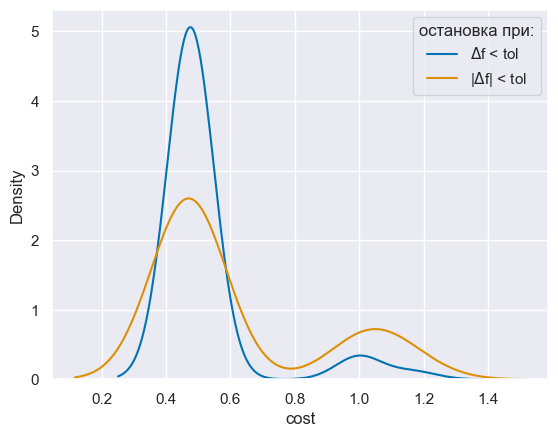

In [181]:
plt.figure(dpi = 100)
sns.kdeplot(f4['cost'], label = '$\Delta$f < tol')
sns.kdeplot(a4['cost'], label = '|$\Delta$f| < tol')
plt.legend(title = "остановка при:")

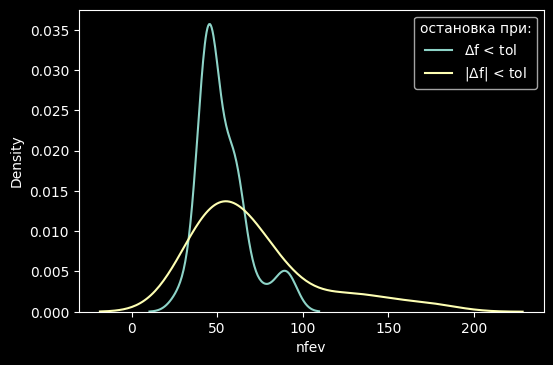

In [20]:
plt.figure(dpi = 100)
sns.kdeplot(f4['nfev'], label = '$\Delta$f < tol')
sns.kdeplot(a4['nfev'], label = '|$\Delta$f| < tol')
plt.legend(title = "остановка при:")

In [56]:
plt.style.use("default")
sns.set_theme()
sns.set_palette('colorblind')

In [208]:
sns.color_palette('colorblind')

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [57]:
sns.set_style({"font": "Times New Roman"})

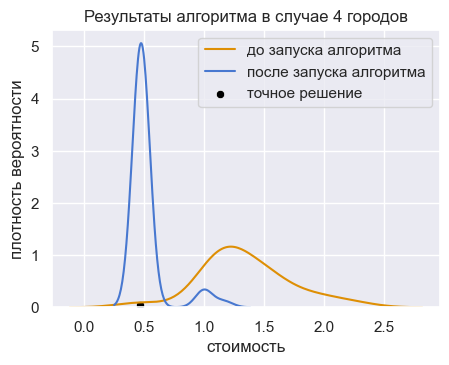

In [358]:
plt.figure(dpi = 100, figsize = (5, 3.6))
ax =\
sns.kdeplot(anal4['answers_table']['cost'] , label = 'до запуска алгоритма', color = sns.color_palette("colorblind")[1])
sns.kdeplot(f4['cost'] , label = 'после запуска алгоритма')
#sns.kdeplot(a4['cost'] , label = 'после запуска алгоритма')
sns.scatterplot(x = [anal4['answers_table']['cost'][anal4['opt_perm_number']]], y = [0.05], color = "black", label = "точное решение", s = 36)
plt.legend()
ax.set_xlabel("стоимость")
ax.set_ylabel("плотность вероятности")
ax.set_title("Результаты алгоритма в случае 4 городов")
plt.savefig("../tex/4towns.pdf", bbox_inches = "tight")

### 6 городов

In [47]:
anal6 = analytical(cost_matrix_6)
anal6['answers_table'].iloc[[anal6['opt_perm_number']]]

,cost
649,0.545867


In [122]:
# 25 sec
f6 = extensively_test_circuit(cost_matrix_6, RxCNOTCircuit(6, 1), abs = False)
f6

,cost,nfev,njev,nhev
0,0.863879,120,0,0
1,0.887305,150,0,0
2,0.831841,90,0,0
3,1.176305,120,0,0
4,1.227434,120,0,0
5,0.751908,90,0,0
6,0.901922,120,0,0
7,0.891058,120,0,0
8,1.342197,120,0,0
9,1.125300,120,0,0


In [148]:
f6_75 = extensively_test_circuit(cost_matrix_6, RxCNOTCircuit(6, 1), repetitions = 75)
f6_75

,cost,nfev,njev,nhev
0,1.219596,150,0,0
1,0.737864,150,0,0
2,0.586804,90,0,0
3,0.745774,150,0,0
4,2.105308,30,0,0
5,0.844650,90,0,0
6,0.742512,120,0,0
7,1.231472,150,0,0
8,0.545867,120,0,0
9,1.201563,120,0,0


In [29]:
a6 = extensively_test_circuit(cost_matrix_6, RxCNOTCircuit(6, 1), abs = True)
a6

,cost,nfev,njev,nhev
0,1.044114,210,0,0
1,1.101640,120,0,0
2,0.556852,390,0,0
3,0.592571,300,0,0
4,1.024108,90,0,0
5,0.592571,270,0,0
6,1.091667,240,0,0
7,0.903261,150,0,0
8,1.135375,450,0,0
9,1.201563,1260,0,0


In [175]:
a6_tol = extensively_test_circuit(cost_matrix_6, RxCNOTCircuit(6, 1), abs = True, tol = 1e-2)

In [176]:
a6_tol

,cost,nfev,njev,nhev
0,1.113177,90,0,0
1,0.721919,120,0,0
2,1.108654,180,0,0
3,0.806489,180,0,0
4,1.091667,150,0,0
5,1.190562,90,0,0
6,0.721919,180,0,0
7,0.736101,90,0,0
8,0.764652,90,0,0
9,1.072229,90,0,0


In [177]:
f6.mean(), a6.mean(), a6_tol.mean()

(cost      1.023127
 nfev    120.600000
 njev      0.000000
 nhev      0.000000
 dtype: float64,
 cost      0.873141
 nfev    337.800000
 njev      0.000000
 nhev      0.000000
 dtype: float64,
 cost      0.948164
 nfev    147.600000
 njev      0.000000
 nhev      0.000000
 dtype: float64)

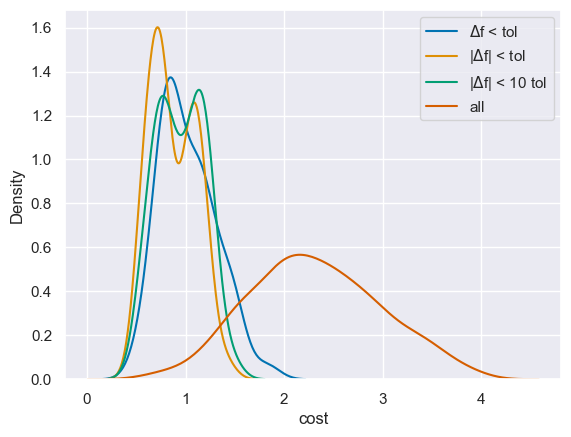

In [203]:
plt.figure(dpi = 100)
sns.kdeplot(f6['cost'], label = '$\Delta$f < tol')
#sns.kdeplot(f6_75['cost'], label = '$\Delta$f < tol, 75 повт.')
sns.kdeplot(a6['cost'], label = '|$\Delta$f| < tol')
sns.kdeplot(a6_tol['cost'], label = '|$\Delta$f| < 10 tol')
sns.kdeplot(anal6['answers_table']['cost'], label = 'all')
plt.legend()

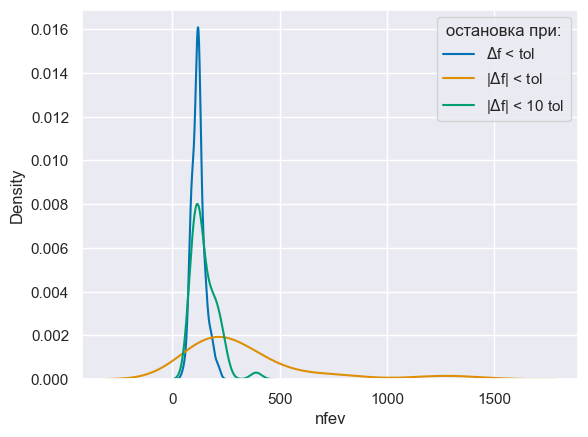

In [253]:
plt.figure(dpi = 100)
sns.kdeplot(f6['nfev'], label = '$\Delta$f < tol')
sns.kdeplot(a6['nfev'], label = '|$\Delta$f| < tol')
sns.kdeplot(a6_tol['nfev'], label = '|$\Delta$f| < 10 tol')
plt.legend(title = "остановка при:")

In [140]:
fh_6 = [RxCNOTCircuit(6, 1).optimize(cost_matrix_6, verbose = True)['cost_history'] for _ in range(4)]

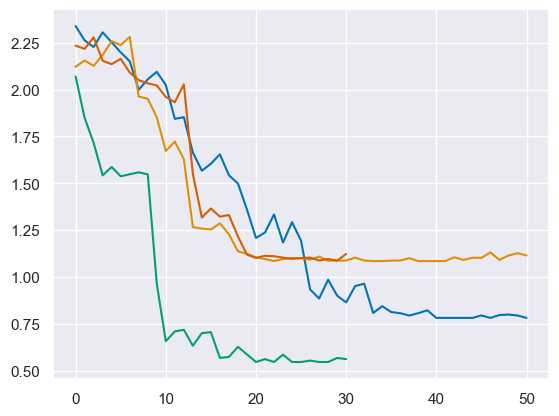

In [141]:
plt.plot(pd.DataFrame(fh_6).transpose())

In [173]:
ah_6 = [RxCNOTCircuit(6, 1).optimize(cost_matrix_6, verbose = True, repetitions=75, abs = True)['cost_history'] for _ in range(4)]

(0.0, 50.0)

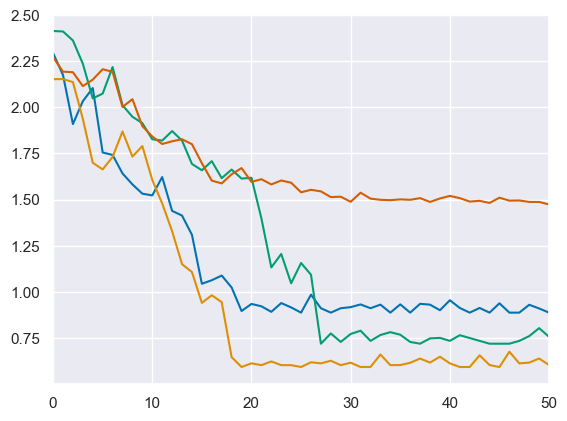

In [174]:
plt.plot(pd.DataFrame(ah_6).transpose())
plt.xlim(0, 50)

In [161]:
rolling_avs = [np.convolve(a, np.ones(3))/3 for a in ah_6]

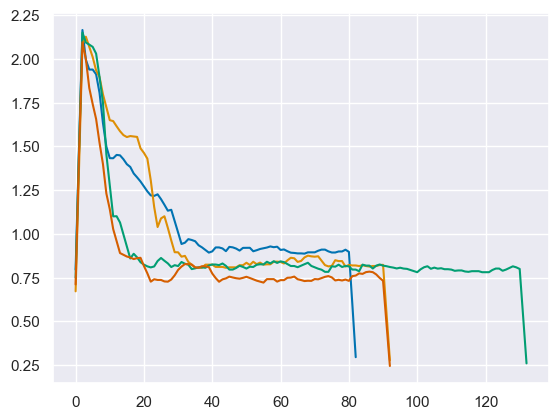

In [162]:
plt.plot(pd.DataFrame(rolling_avs).transpose())

### 8 Городов

In [59]:
anal8 = analytical(cost_matrix_8)
anal8['answers_table'].iloc[[anal8['opt_perm_number']]]

,cost
35577,1.464352


In [50]:
f8 = extensively_test_circuit(cost_matrix_8, RxCNOTCircuit(8, 1))
f8

,cost,nfev,njev,nhev
0,1.787046,288,0,0
1,1.539058,240,0,0
2,2.023303,288,0,0
3,2.071798,240,0,0
4,1.876805,240,0,0
5,2.007658,336,0,0
6,2.196086,288,0,0
7,1.714119,192,0,0
8,2.317960,288,0,0
9,1.701269,240,0,0


In [224]:
f8.mean()

cost      1.916372
nfev    253.440000
njev      0.000000
nhev      0.000000
dtype: float64

In [252]:
a8_tol = extensively_test_circuit(cost_matrix_8, RxCNOTCircuit(8, 1), tol = 1e-2, abs = True)
a8_tol

,cost,nfev,njev,nhev
0,2.028516,192,0,0
1,1.707650,192,0,0
2,1.527982,336,0,0
3,1.714907,336,0,0
4,2.212607,432,0,0
5,1.762636,144,0,0
6,2.225103,384,0,0
7,1.858403,240,0,0
8,1.695779,192,0,0
9,1.667523,384,0,0


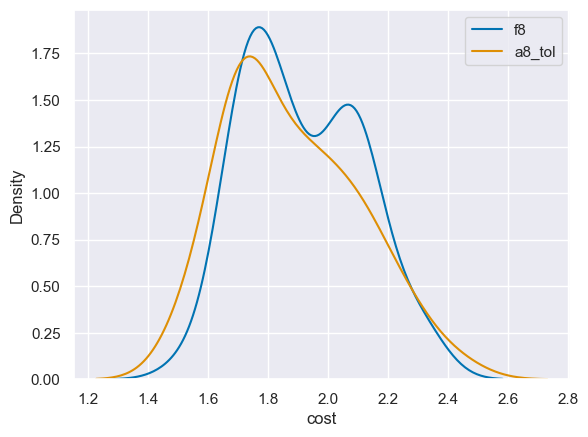

In [254]:
plt.figure(dpi = 100)
sns.kdeplot(f8['cost'], label = 'f8')
sns.kdeplot(a8_tol['cost'], label = 'a8_tol')
plt.legend()

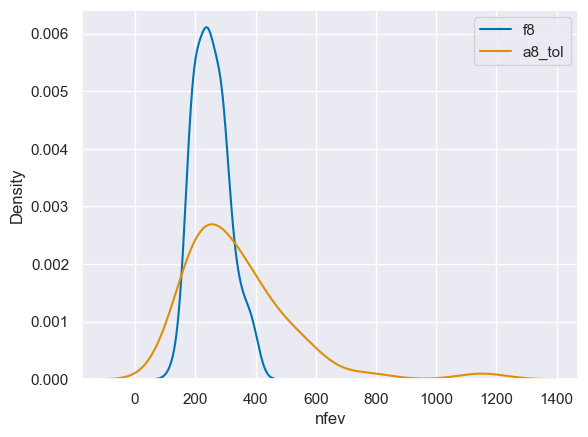

In [255]:
plt.figure(dpi = 100)
sns.kdeplot(f8['nfev'], label = 'f8')
sns.kdeplot(a8_tol['nfev'], label = 'a8_tol')
plt.legend()

### 10 городов

In [64]:
anal10 = analytical(cost_matrix_10)
anal10['answers_table'].iloc[[anal10['opt_perm_number']]]

,cost
1248354,0.836561


In [60]:
# 30 min
f10 = extensively_test_circuit(cost_matrix_10, RxCNOTCircuit(10, 1))
f10

,cost,nfev,njev,nhev
0,2.686780,330,0,0
1,1.505111,330,0,0
2,1.399107,198,0,0
3,2.326404,264,0,0
4,2.846409,264,0,0
5,1.737855,330,0,0
6,2.817570,462,0,0
7,1.650504,528,0,0
8,4.406672,66,0,0
9,2.445617,264,0,0


In [192]:
a10_tol = extensively_test_circuit(cost_matrix_10, RxCNOTCircuit(10, 1), abs = True, tol = 1e-2)
a10_tol

,cost,nfev,njev,nhev
0,1.835157,462,0,0
1,1.526082,264,0,0
2,1.441352,396,0,0
3,1.800946,1452,0,0
4,2.156264,792,0,0
5,2.347564,330,0,0
6,2.091931,1386,0,0
7,1.107263,1716,0,0
8,1.612038,792,0,0
9,2.298474,1188,0,0


In [71]:
f10.mean()

cost      2.626095
nfev    315.480000
njev      0.000000
nhev      0.000000
dtype: float64

In [196]:
a10_tol.mean()

cost      2.025416
nfev    741.840000
njev      0.000000
nhev      0.000000
dtype: float64

<AxesSubplot:xlabel='cost', ylabel='Density'>

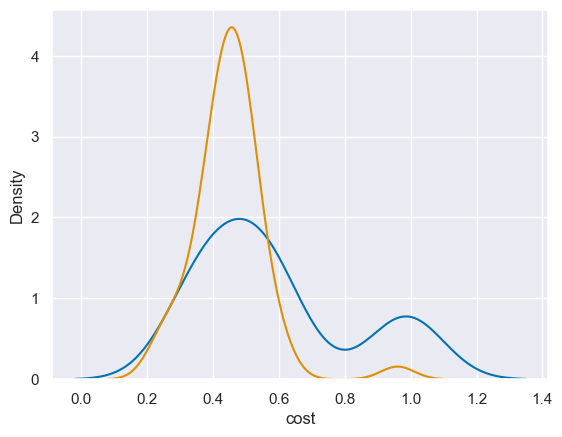

In [195]:
sns.kdeplot(f10['cost'] / anal10['answers_table']['cost'].mean())
sns.kdeplot(a10_tol['cost'] / anal10['answers_table']['cost'].mean())

### Сводная диаграмма

In [197]:
f4_ = f4[['cost', 'nfev']].copy()
f4_['cost'] /= anal4['answers_table']['cost'].mean()

f6_ = a6_tol[['cost', 'nfev']].copy()
f6_['cost'] /= anal6['answers_table']['cost'].mean()

f8_ = f8[['cost', 'nfev']].copy()
f8_['cost'] /= anal8['answers_table']['cost'].mean()

f10_ = a10_tol[['cost', 'nfev']].copy()
f10_['cost'] /= anal10['answers_table']['cost'].mean()

In [198]:
f_all = pd.concat([f4_, f6_, f8_, f10_], keys = [4, 6, 8, 10], names = ["n_towns"])
f_all

cost  nfev
n_towns                   
4       0   0.347682    45
        1   0.355237    60
        2   0.347682    45
        3   0.347682    45
        4   0.347682    60
...              ...   ...
10      45  0.486789   594
        46  0.415361   528
        47  0.494368   462
        48  0.482431   660
        49  0.462736   660

[200 rows x 2 columns]

In [184]:
anal4_ = anal4['answers_table'] / anal4['answers_table']['cost'].mean()

anal6_ = anal6['answers_table'] / anal6['answers_table']['cost'].mean()

anal8_ = anal8['answers_table'] / anal8['answers_table']['cost'].mean()

anal10_ = anal10['answers_table'] / anal10['answers_table']['cost'].mean()

In [185]:
anal_all = pd.concat([anal4_, anal6_, anal8_, anal10_], keys = [4, 6, 8, 10], names = ["n_towns"])

In [211]:
all_all = pd.concat([f_all, anal_all], keys = ["anal", "f"], names = ["_"])

In [187]:
normalized_best_costs = [
    [4, anal4['answers_table']['cost'][anal4['opt_perm_number']] / anal4['answers_table']['cost'].mean()],
    [6, anal6['answers_table']['cost'][anal6['opt_perm_number']] / anal6['answers_table']['cost'].mean()], 
    [8, anal8['answers_table']['cost'][anal8['opt_perm_number']] / anal8['answers_table']['cost'].mean()],
    [10, anal10['answers_table']['cost'][anal10['opt_perm_number']] / anal10['answers_table']['cost'].mean()]
]
normalized_best_costs

[[4, 0.34768191746048205],
 [6, 0.23556902867347632],
 [8, 0.40551232656449193],
 [10, 0.18612469023670253]]

In [188]:
true_sols = pd.DataFrame(normalized_best_costs, columns = ["n_towns", "normalized_cost"])

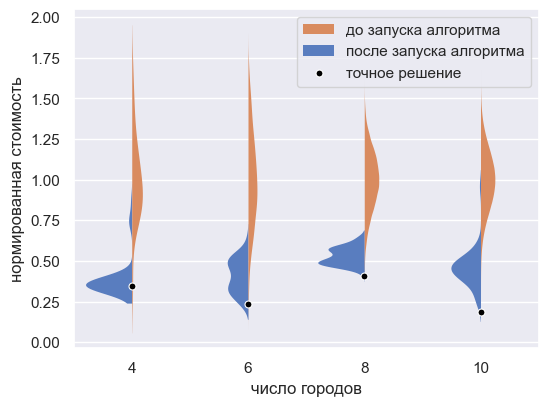

In [362]:
plt.figure(figsize = (6, 4.4), dpi = 100)
sns.violinplot(data = all_all.reset_index(), 
               x = 'n_towns', y = 'cost', 
               hue = "_", 
               split = True, 
               linewidth = 0,
               #bw = 0.25,
               scale_hue = False,
               #scale = "width"
        )
sns.stripplot(data = true_sols, x = 'n_towns', y = 'normalized_cost', color = 'black', jitter = False, label = 'точное решение', linewidth = 0.8, edgecolor = 'white')
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles = [handles[1], handles[0], handles[2]], labels = ["до запуска алгоритма", "после запуска алгоритма", "точное решение"])
ax.set_xlabel("число городов")
ax.set_ylabel("нормированная стоимость")
plt.savefig("./violin.pdf", dpi = 300, bbox_inches = "tight")

### Сложность

In [ ]:
better_shares = [
    np.sum(anal4['answers_table']['cost'] < f4['cost'].mean()) / factorials[4],
    np.sum(anal6['answers_table']['cost'] < f6['cost'].mean()) / factorials[6],
    np.sum(anal8['answers_table']['cost'] < f8['cost'].mean()) / factorials[8],
    np.sum(anal10['answers_table']['cost'] < a10_tol['cost'].mean()) / factorials[10],
]
better_shares

[0.041666666666666664,
 0.016666666666666666,
 0.0038442460317460315,
 0.0010940255731922398]

In [ ]:
1 / np.array(better_shares)

array([ 24.        ,  65.45454545, 260.12903226, 914.05541562])

In [ ]:
nfevs = [
    f4['nfev'].mean(),
    f6['nfev'].mean(),
    f8['nfev'].mean(),
    a10_tol['nfev'].mean(),
]
nfevs

[53.4, 120.6, 253.44, 741.84]

In [ ]:
performances = np.array(better_shares) * np.array(nfevs)

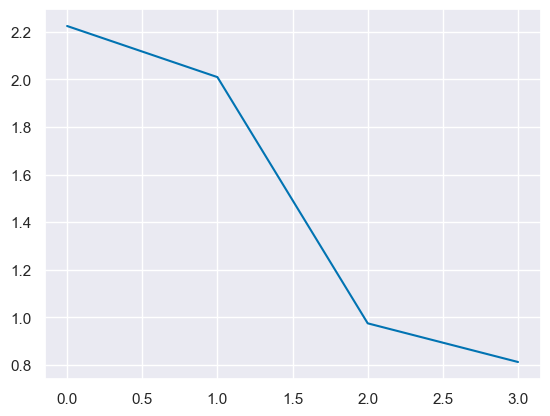

In [ ]:
plt.plot(performances)

In [235]:
costs_4 = anal4['answers_table']['cost'].sort_values(ignore_index = True)
costs_6 = anal6['answers_table']['cost'].sort_values(ignore_index = True)
costs_8 = anal8['answers_table']['cost'].sort_values(ignore_index = True)
costs_10 = anal10['answers_table']['cost'].sort_values(ignore_index = True)

In [365]:
def calc_nfev_bs(df, n_towns, all_costs_sorted):
    df['rank'] = all_costs_sorted.searchsorted(df['cost'])
    df['rank'] += np.isclose(df['cost'], all_costs_sorted[df['rank']]) # иначе иногда получается rank = 0
    df['percentile_rank'] = df['rank'] / factorials[n_towns]
    df['nfev * pr'] = df['nfev'] * df['percentile_rank']
    df['N_cycles'] = df['nfev'] / np.ceil(np.log2(factorials[n_towns]))
    return df

In [366]:
calc_nfev_bs(f4, 4, costs_4)
calc_nfev_bs(a4, 4, costs_4)

calc_nfev_bs(f6, 6, costs_6)
calc_nfev_bs(a6, 6, costs_6)
calc_nfev_bs(a6_tol, 6, costs_6)

calc_nfev_bs(f8, 8, costs_8)
calc_nfev_bs(a8_tol, 8, costs_8)

calc_nfev_bs(f10, 10, costs_10)
calc_nfev_bs(a10_tol, 10, costs_10);

In [262]:
f4['nfev * bs'] = f4['nfev'] * f4['better_share']
f6['nfev * bs'] = f6['nfev'] * f6['better_share']
f8['nfev * bs'] = f8['nfev'] * f8['better_share']
f10['nfev * bs'] = f10['nfev'] * f10['better_share']

a4['nfev * bs'] = a4['nfev'] * a4['better_share']
a6['nfev * bs'] = a6['nfev'] * a6['better_share']
a6_tol['nfev * bs'] = a6_tol['nfev'] * a6_tol['better_share']
a8_tol['nfev * bs'] = a8_tol['nfev'] * a8_tol['better_share']
a10_tol['nfev * bs'] = a10_tol['nfev'] * a10_tol['better_share']

In [268]:
a10_tol['nfev * bs'].median(), a10_tol['nfev * bs'].std()

(0.6664657738095238, 7.962222311790866)

In [368]:
trxye = pd.concat([f4, a6_tol, f8, a10_tol], keys = [4, 6, 8, 10], names = ["n_towns"])

In [348]:
sns.set_palette('muted')

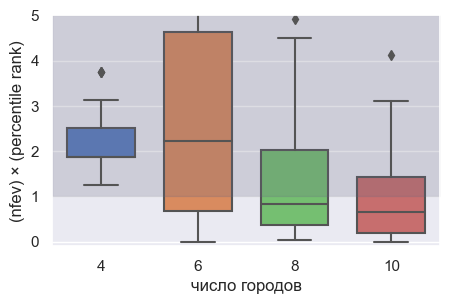

In [349]:
plt.figure(figsize = (5, 3), dpi = 100)
sns.boxplot(data = trxye.reset_index(), 
            x = 'n_towns', y = 'nfev * bs',
            width = 0.7
        )
ax = plt.gca()
ax.set_xlabel("число городов")
ax.set_ylabel("(nfev) × (percentile rank)")
ax.set_ylim(-0.1, 5)
plt.fill_between([-0.5, 3.5], [1, 1], [5, 5], color = (0.4, 0.4, 0.5, 0.22))
#plt.savefig("../tex/percentile.pdf", dpi = 300, bbox_inches = "tight")

(0.0, 40.0)

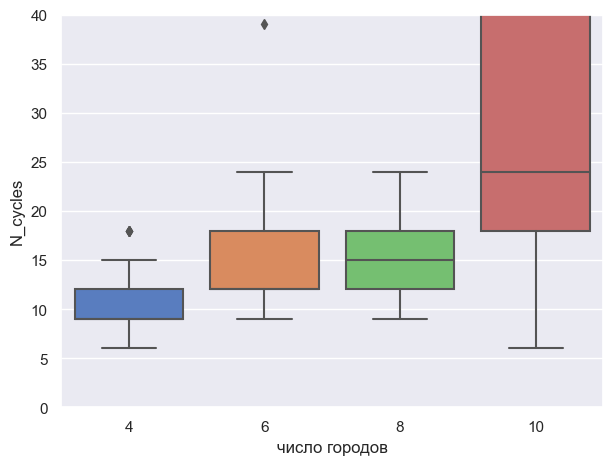

In [370]:
plt.figure(figsize = (7, 5.1), dpi = 100)
sns.boxplot(data = trxye.reset_index(), 
            x = 'n_towns', y = 'N_cycles', 
        )
ax = plt.gca()
ax.set_xlabel("число городов")
#ax.set_ylabel("число затраченных циклов")
ax.set_ylim(0, 40)

In [374]:
from numpy import median

<AxesSubplot:xlabel='n_towns', ylabel='N_cycles'>

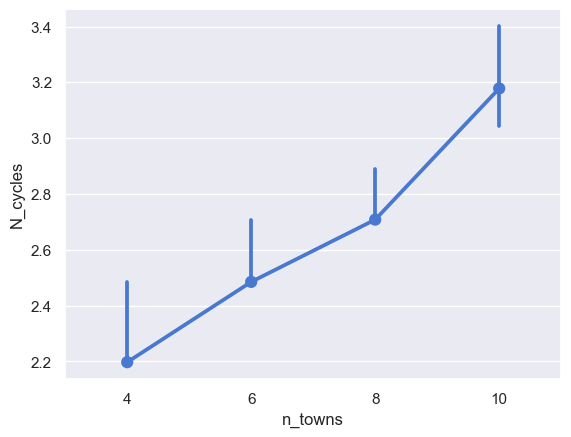

In [376]:
sns.pointplot(data = np.log(trxye['N_cycles']).reset_index(), x = 'n_towns', y = 'N_cycles',estimator = median)

In [377]:
import dill

In [380]:
dill.dump_session('./cicrcuit1.pkl')

PicklingError: Can't pickle <function _make_type_validator.<locals>.validate_int at 0x104cbfa60>: it's not found as matplotlib.rcsetup._make_type_validator.<locals>.validate_int